In [ ]:
!pip install leidenalg python-igraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 9.4 MB/s eta 0:00:00


In [ ]:
pip install python-louvain

In [ ]:
import re
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import leidenalg as la
import igraph as ig
from leidenalg import find_partition
from collections import defaultdict, Counter

Number of unique words for class 0 before filtering appear more than 2: 371
Number of unique words for class 1 before filtering appear more than 2: 467
Number of unique words for class 2 before filtering appear more than 2: 110
Number of unique words for class 0 after filtering appear more than 2: 42
Number of unique words for class 1 after filtering appear more than 2: 51
Number of unique words for class 2 after filtering appear more than 2: 25


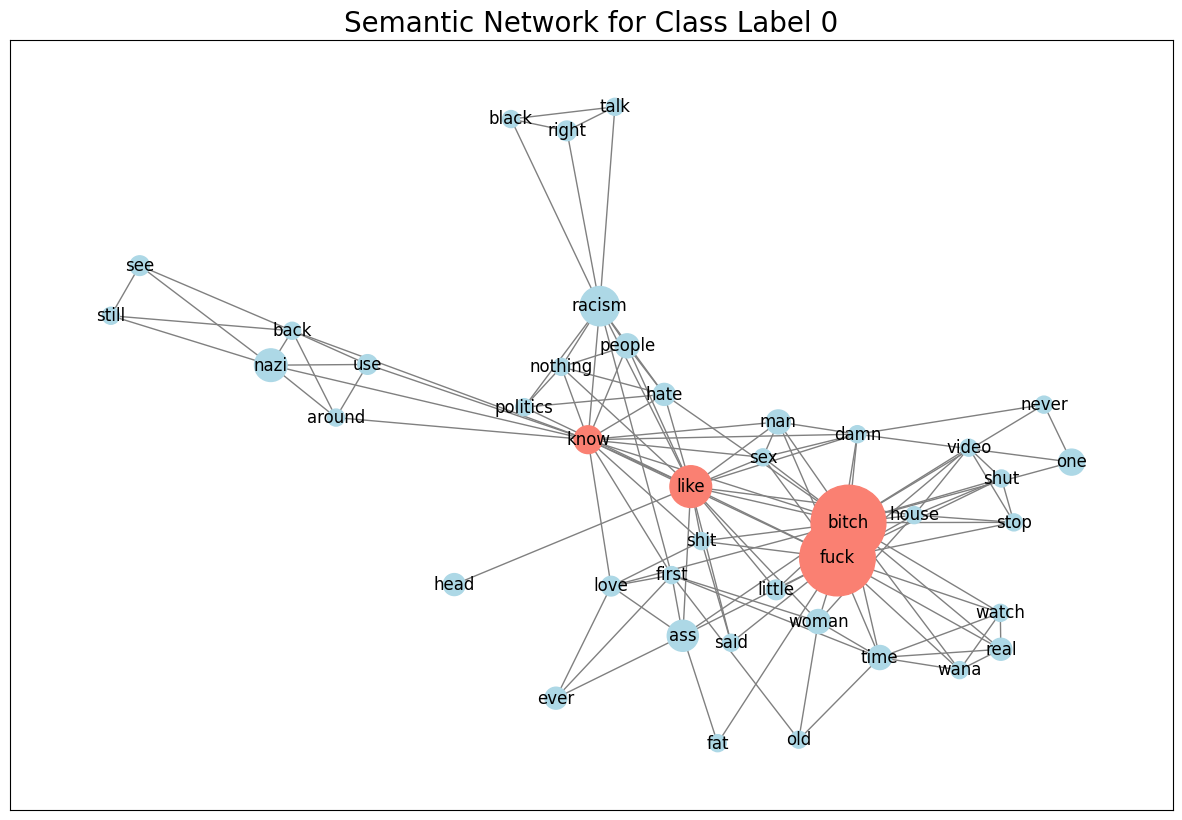

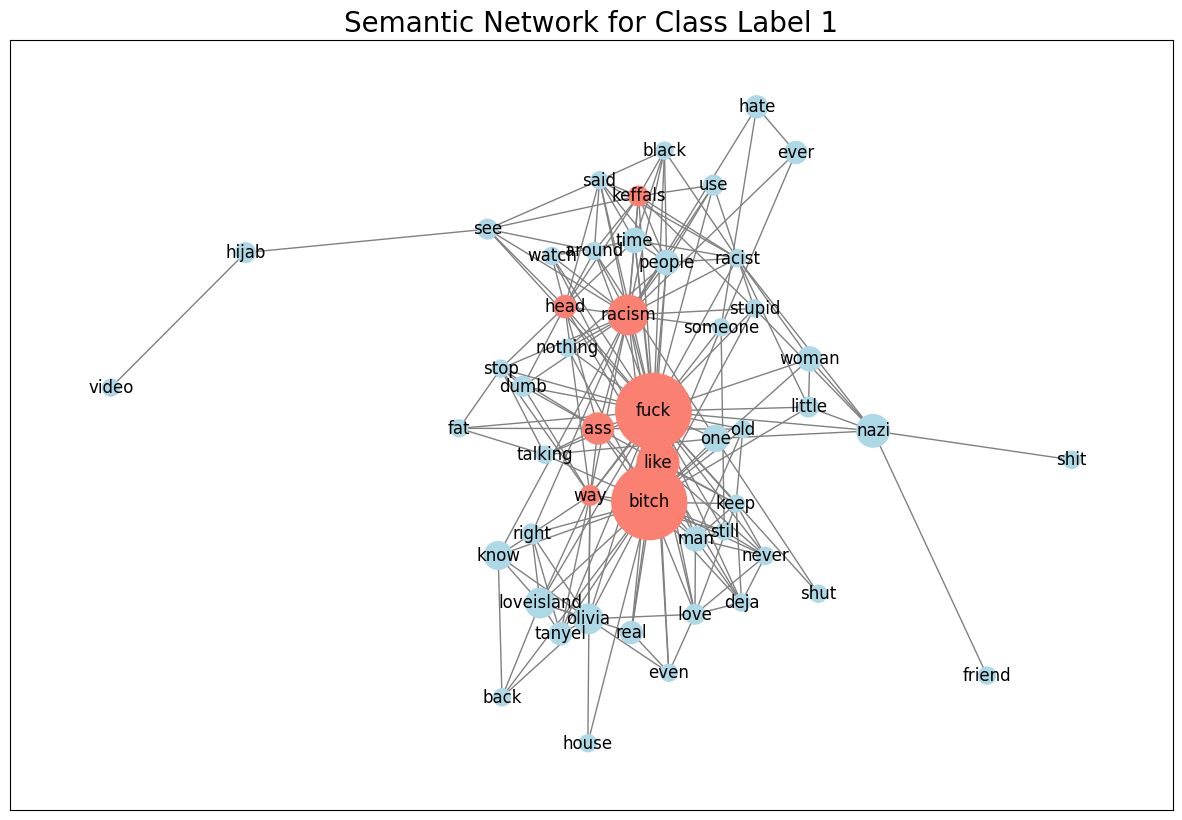

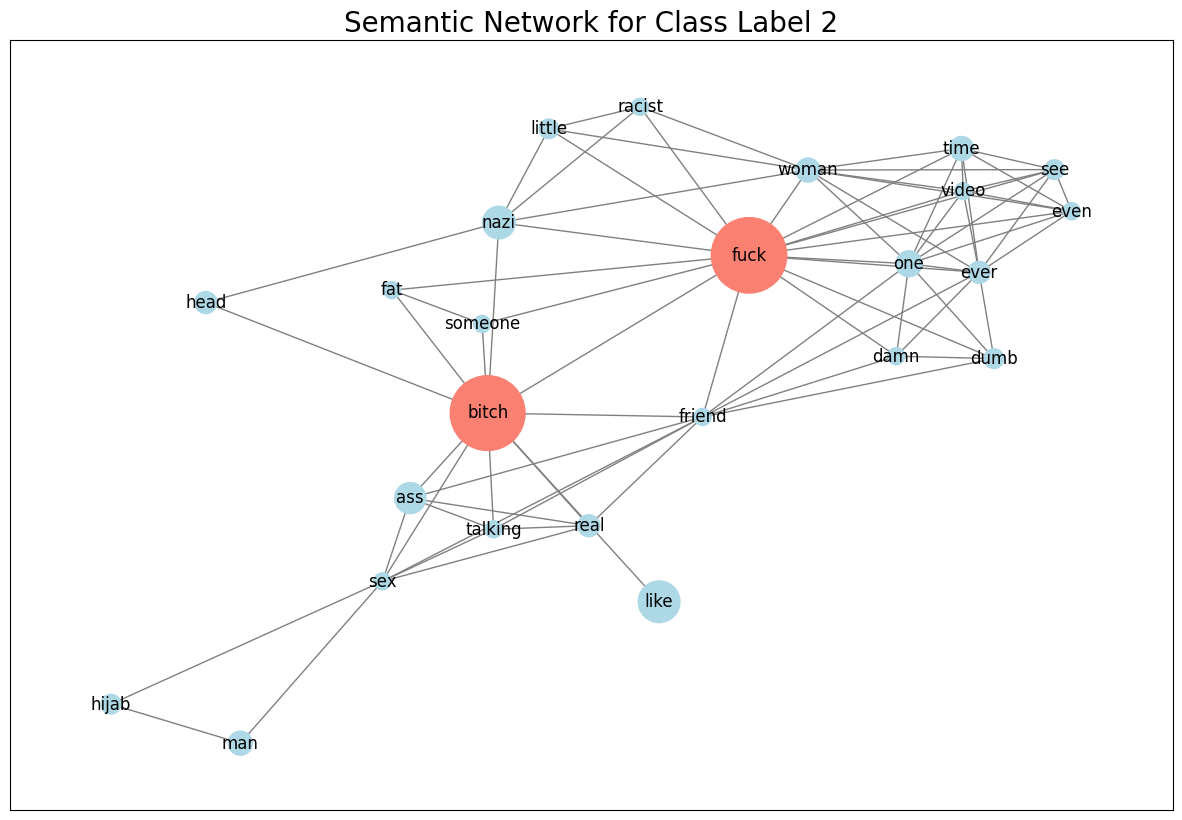

In [ ]:
# Custom stemming function to reduce words to their base form
def custom_stem(word):
    # Simple rules for common variations
    stem_map = {
        'fuck': ['fuck', 'fucking', 'fuckingg', 'fucked', 'fucker', 'fuckers', 'tf','wtf'],
        'shit': ['shit', 'shitting', 'shitty', 'shitted'],
        'damn': ['damn', 'damned', 'damning', 'dammit'],
        'love': ['love','loves', 'loving', 'loved'],
        'hate': ['hate', 'hating', 'hated', 'hates'],

    }
    for base, variations in stem_map.items():
        if word in variations:
            return base
    return word

def preprocess_text_simple(text):
    if isinstance(text, float):
        return []
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize by splitting the text
    tokens = text.split()
    # Remove stopwords (using a simple hardcoded list)
    stop_words = set([
        'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
        'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself',
        'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
        'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be',
        'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an',
        'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for',
        'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above',
        'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again',
        'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any',
        'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only',
        'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should',
        'now', 'always', 'dont', 'doesnt', 'thats', 'cant', 'wont', 'wouldnt', 'shouldnt', 'couldnt', 'cannot',
        'will', 'didnt', 'shes', 'im', 'make', 'makes', 'made', 'havent', 'want', 'wants', 'etc', 'could',
        'without', 'theyre', 'making', 'another', 'many', 'u', 'yo','us', 'youre', 'every',
        'hes', 'also', 'yall', 'aint', 'trying', 'whole', 'would', 'get', 'gets', 'got'
    ])
    tokens = [custom_stem(word) for word in tokens if word not in stop_words and 'https' not in word and len(word) <= 10]
    return tokens

# Load the data
df_filtered = pd.read_excel('202305_CYBERBYSTANDER (CYBY23) dataset.xlsx')

# Drop rows with NaN values in 'Class label' column
df_filtered = df_filtered.dropna(subset=['Class label', 'text'])

# Create a dictionary to hold text data for each tweet
tweet_words = defaultdict(list)
word_counter = Counter()
for _, row in df_filtered.iterrows():
    tweet_id = row['tweet_id']
    tokens = preprocess_text_simple(row['text'])
    tweet_words[tweet_id].extend(tokens)
    word_counter.update(tokens)

# Count and print the number of unique words before filtering for each class
word_counter_per_class = defaultdict(Counter)
for _, row in df_filtered.iterrows():
    class_label = int(row['Class label'])
    tokens = preprocess_text_simple(row['text'])
    word_counter_per_class[class_label].update(tokens)

# Count and print the number of unique words before filtering
for class_label in [0, 1, 2]:
    unique_words_before = len(word_counter_per_class[class_label])
    print(f"Number of unique words for class {class_label} before filtering appear more than 2: {unique_words_before}")


# Filter words that appear more than 2 times
filtered_words = {word for word, count in word_counter.items() if count > 2}

# Count and print the number of unique words after filtering for each class
filtered_word_counter_per_class = defaultdict(Counter)
for _, row in df_filtered.iterrows():
    class_label = int(row['Class label'])
    tokens = [word for word in preprocess_text_simple(row['text']) if word in filtered_words]
    filtered_word_counter_per_class[class_label].update(tokens)

# Count and print the number of unique words after filtering
for class_label in [0, 1, 2]:
    unique_words_after = len(filtered_word_counter_per_class[class_label])
    print(f"Number of unique words for class {class_label} after filtering appear more than 2: {unique_words_after}")

# Create semantic networks for each class label
class_networks = defaultdict(nx.Graph)
for _, row in df_filtered.iterrows():
    class_label = int(row['Class label'])
    tweet_id = row['tweet_id']
    tokens = [word for word in preprocess_text_simple(row['text']) if word in filtered_words]
    for i, word1 in enumerate(tokens):
        for word2 in tokens[i+1:]:
           if word1 != word2:
            class_networks[class_label].add_edge(word1, word2)

# Function to plot a network
def plot_network(graph, title):
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(graph, seed=42, k=0.3)  # for consistent layout
    degrees = dict(graph.degree())
    node_colors = ['salmon' if degrees[node] > 10 else 'lightblue' for node in graph.nodes()]

    # Node sizes based on word count
    node_sizes = [word_counter[node] * 50 for node in graph.nodes()]

    nx.draw_networkx(graph, pos, with_labels=True, node_size=node_sizes, font_size=12, edge_color="gray", node_color=node_colors)

    plt.title(title, fontsize=20)
    plt.show()

# Plot networks for each class label
for class_label in [0, 1, 2]:
    if class_label in class_networks:
        plot_network(class_networks[class_label], f"Semantic Network for Class Label {class_label}")

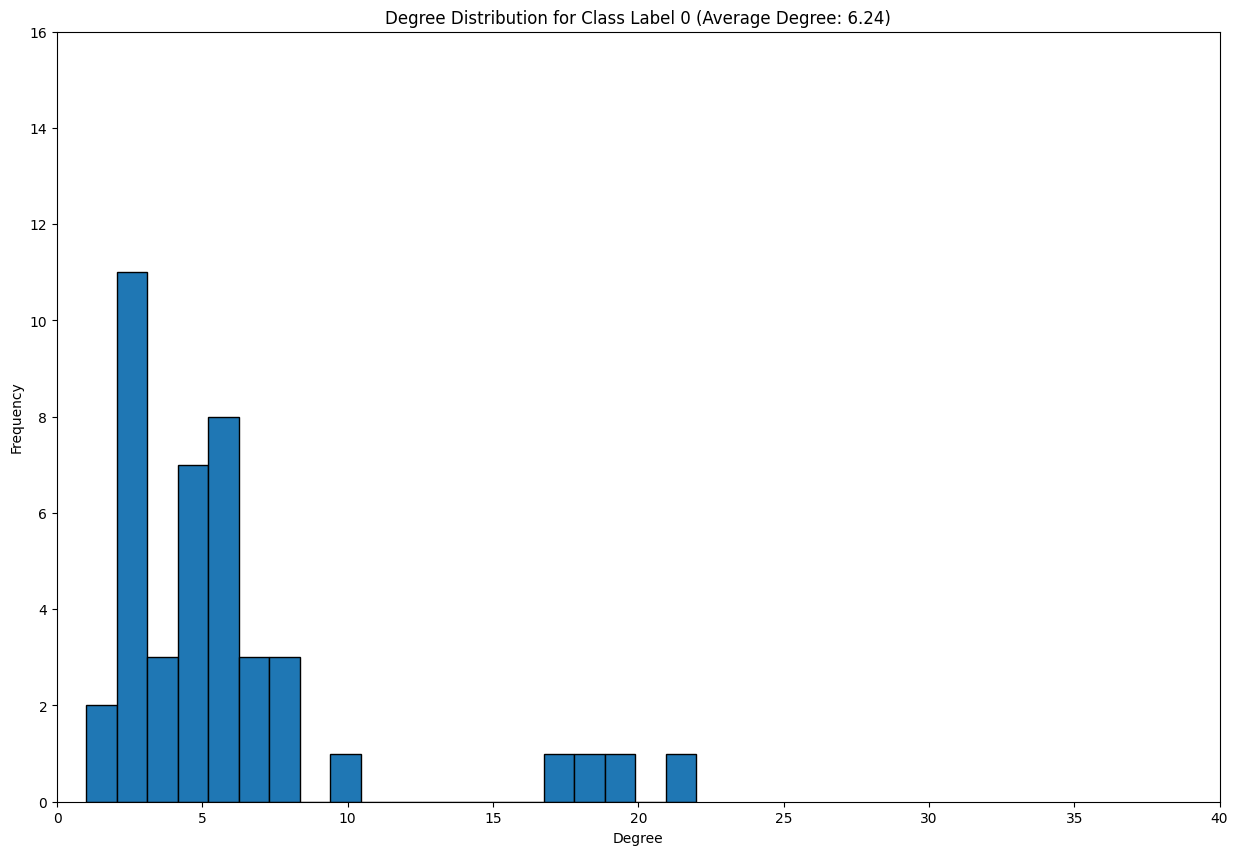

Degree Distribution for Class Label 0
 Rank     Word  Degree
    1    bitch      22
    2     fuck      19
    3     like      18
    4     know      17
    5   racism      10
    6    first       8
    7     time       8
    8     damn       8
    9     hate       7
   10      ass       7
   11    house       7
   12     nazi       6
   13     back       6
   14  nothing       6
   15    woman       6
   16     shit       6
   17      sex       6
   18      man       6
   19     love       6
   20   people       5
   21     stop       5
   22    video       5
   23     shut       5
   24     wana       5
   25    watch       5
   26     real       5
   27      use       4
   28   around       4
   29 politics       4
   30    still       3
   31      see       3
   32      old       3
   33    black       3
   34     talk       3
   35    right       3
   36     said       3
   37   little       3
   38      one       3
   39    never       3
   40     ever       3
   41      fat     

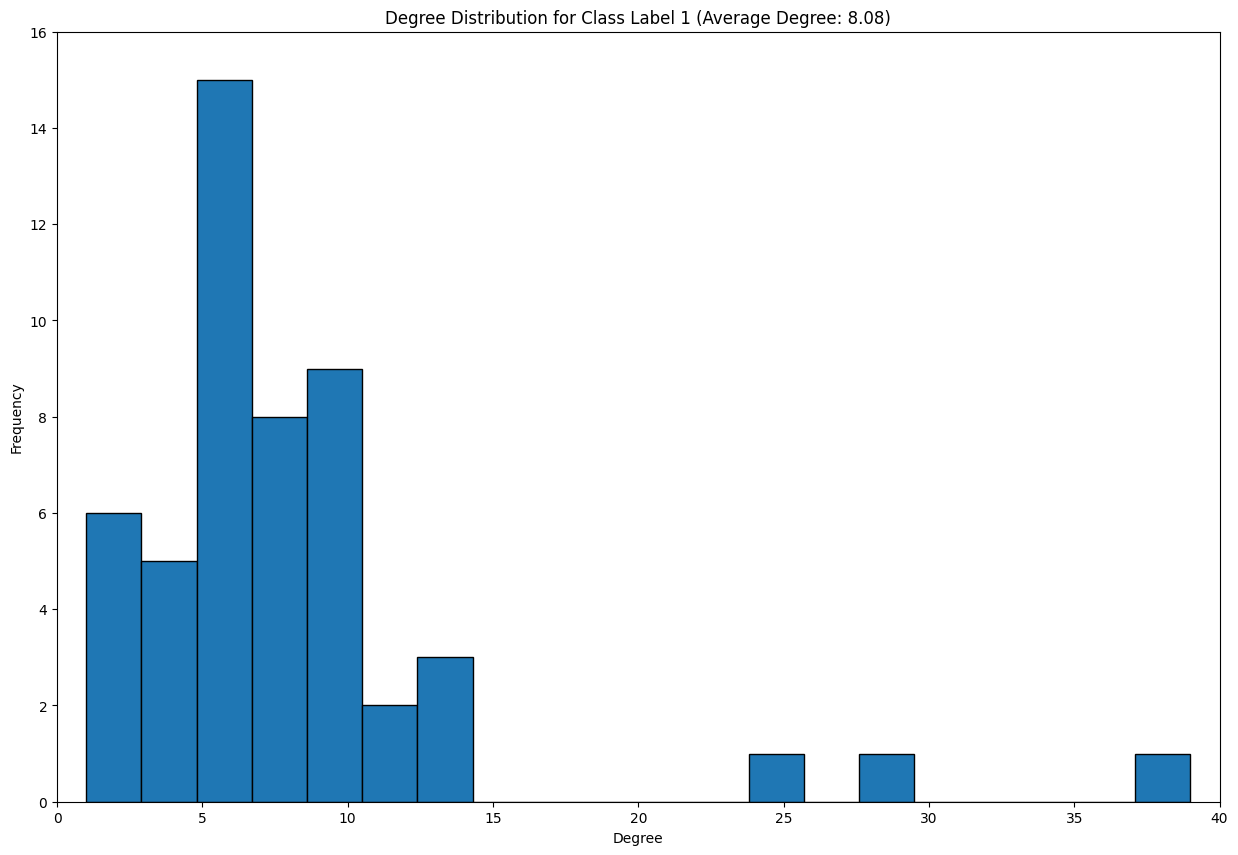

Degree Distribution for Class Label 1
 Rank       Word  Degree
    1       fuck      39
    2      bitch      28
    3     racism      25
    4        way      14
    5       head      13
    6       like      13
    7    keffals      12
    8        ass      12
    9       said      10
   10       time      10
   11     racist      10
   12     people      10
   13        man      10
   14     olivia      10
   15 loveisland       9
   16       love       9
   17       keep       9
   18       nazi       8
   19       stop       8
   20      never       8
   21     around       7
   22        see       7
   23      right       7
   24      black       7
   25       deja       7
   26       know       6
   27        one       6
   28       dumb       6
   29    someone       6
   30     stupid       6
   31    talking       6
   32      still       6
   33     tanyel       6
   34      watch       5
   35        use       5
   36       real       5
   37       even       5
   38      w

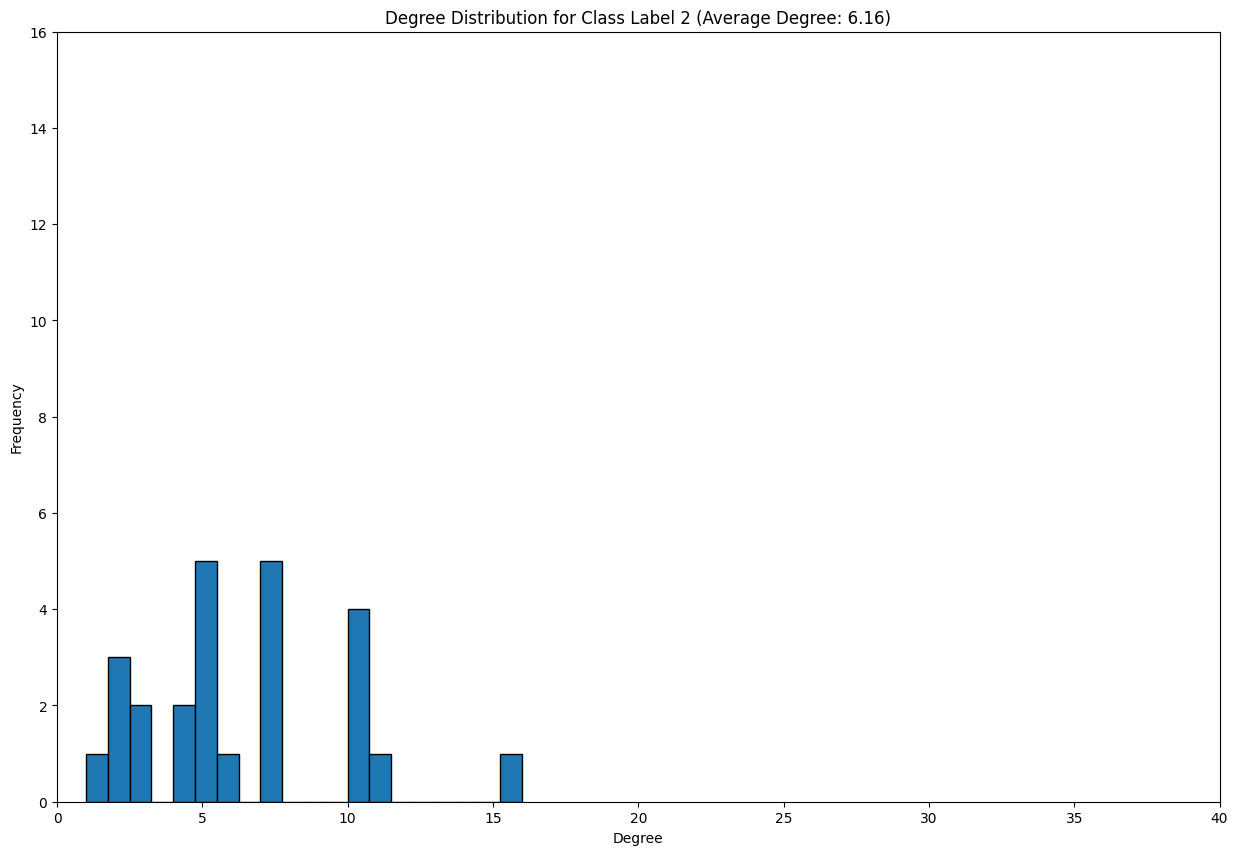

Degree Distribution for Class Label 2
 Rank    Word  Degree
    1    fuck      16
    2   bitch      11
    3   woman      10
    4     one      10
    5  friend      10
    6    ever      10
    7     sex       7
    8    even       7
    9    time       7
   10     see       7
   11   video       7
   12    nazi       6
   13    dumb       5
   14    damn       5
   15     ass       5
   16    real       5
   17 talking       5
   18  little       4
   19  racist       4
   20 someone       3
   21     fat       3
   22   hijab       2
   23     man       2
   24    head       2
   25    like       1


In [ ]:
for class_label in [0, 1, 2]:
    if class_label in class_networks:
        graph = class_networks[class_label]

        # Calculate degrees for words in the network
        degrees = {n: d for n, d in graph.degree() if n in filtered_words}

        # Sort the degrees and index them from 1 for the highest degree vertex
        sorted_degrees = sorted(degrees.items(), key=lambda item: item[1], reverse=True)

        # Extract words and their degrees
        words = [word for word, _ in sorted_degrees]
        degrees = [degree for _, degree in sorted_degrees]

        # Calculate average degree
        avg_degree = sum(degrees) / len(degrees) if degrees else 0

        # Plotting the degree distribution
        plt.figure(figsize=(15, 10))
        plt.hist(degrees, bins=20, edgecolor='black')
        plt.title(f'Degree Distribution for Class Label {class_label} (Average Degree: {avg_degree:.2f})')
        plt.xlabel('Degree')
        plt.ylabel('Frequency')
        plt.xlim(0, 40)
        plt.ylim(0, 16)
        plt.show()

        # Create a DataFrame to display word and its degree
        df_degrees = pd.DataFrame({'Rank': range(1, len(words) + 1), 'Word': words, 'Degree': degrees})
        print(f'Degree Distribution for Class Label {class_label}')
        print(df_degrees.head(100).to_string(index=False))


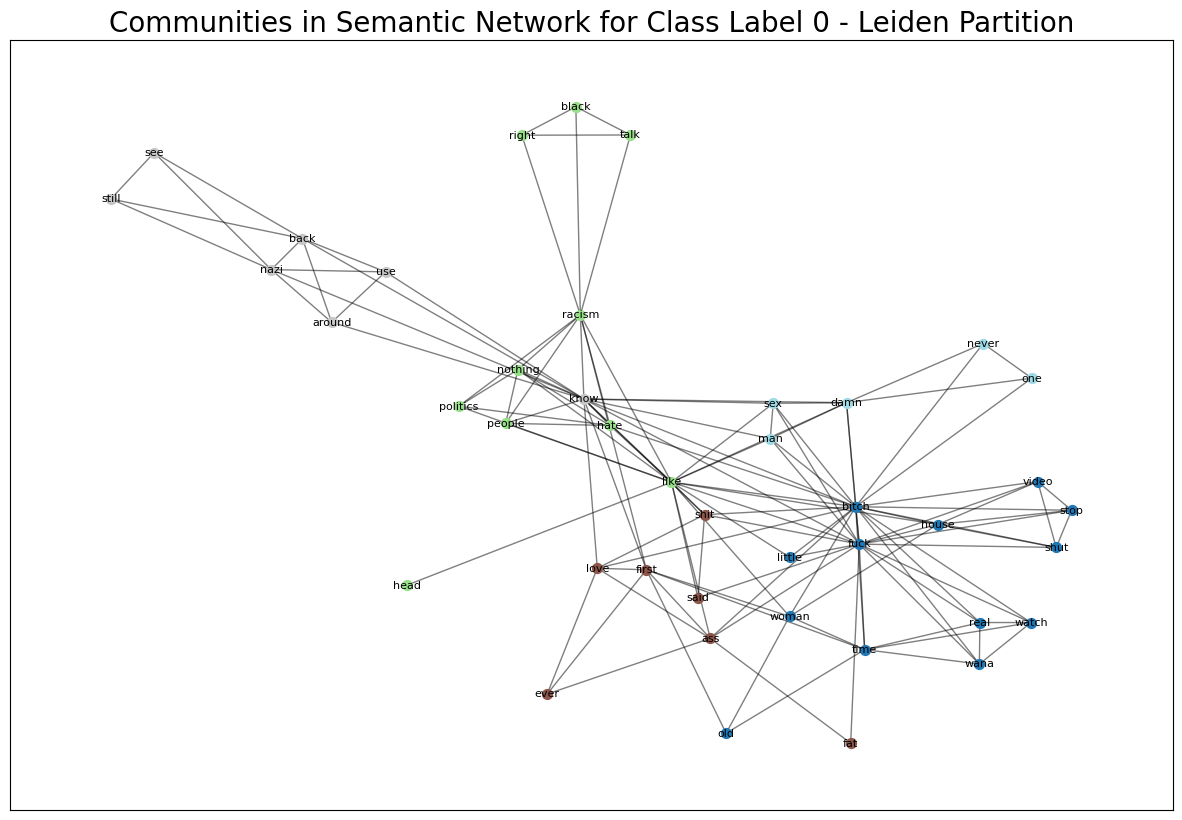

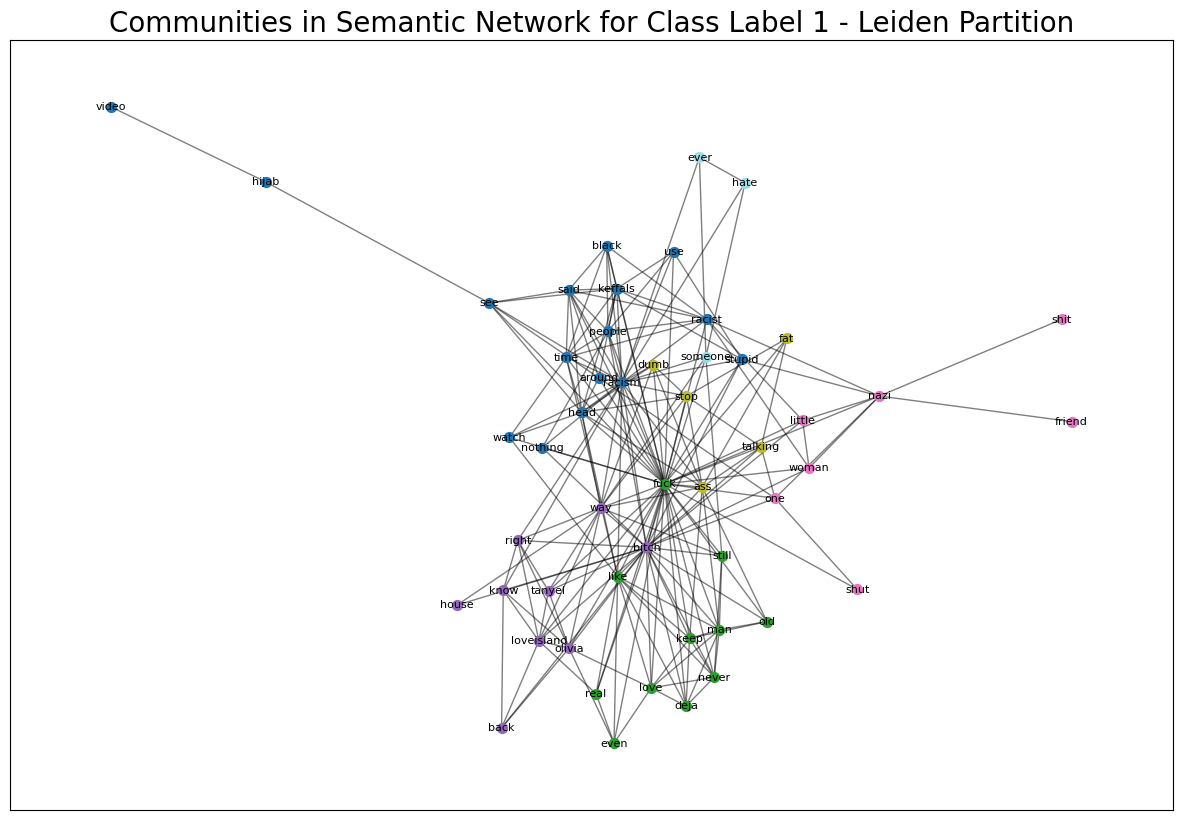

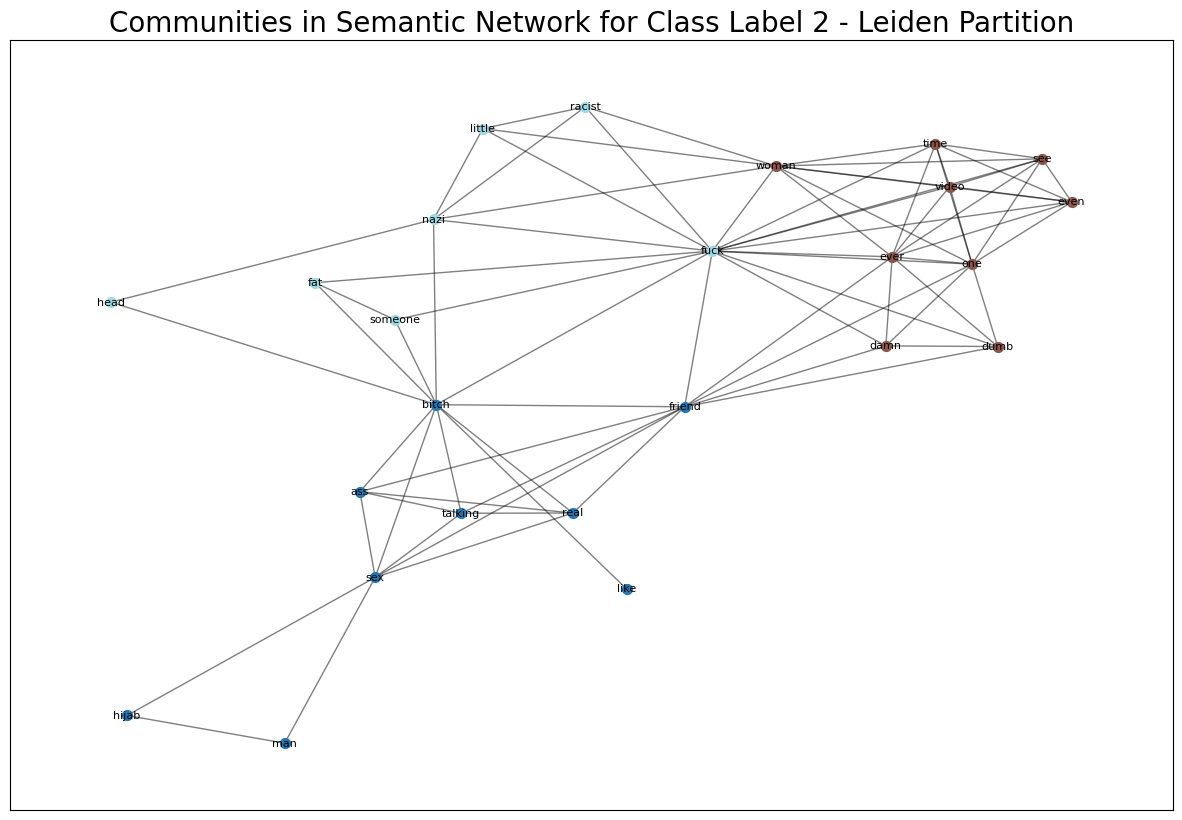

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import igraph as ig
import leidenalg as la
import numpy as np

# Convert NetworkX graph to igraph
def nx_to_igraph(nx_graph):
    mapping = {node: idx for idx, node in enumerate(nx_graph.nodes())}
    reverse_mapping = {idx: node for node, idx in mapping.items()}
    ig_graph = ig.Graph(directed=False)
    ig_graph.add_vertices(len(nx_graph.nodes()))
    ig_graph.add_edges([(mapping[u], mapping[v]) for u, v in nx_graph.edges()])
    return ig_graph, reverse_mapping

# Plot communities
def plot_communities(nx_graph, partition, title):
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(nx_graph, seed=42)

    # Assign a unique color to each community
    color_map = plt.get_cmap('tab20')
    colors = color_map(np.linspace(0, 1, len(partition)))

    for community_index, community in enumerate(partition):
        nx.draw_networkx_nodes(nx_graph, pos, nodelist=community, node_color=[colors[community_index]], node_size=50)
    nx.draw_networkx_edges(nx_graph, pos, alpha=0.5)
    nx.draw_networkx_labels(nx_graph, pos, font_size=8, font_color='black')


    plt.title(title, fontsize=20)
    plt.show()

# Create and plot communities for each class label

for class_label in [0, 1, 2]:
    if class_label in class_networks:
        graph = class_networks[class_label]
        ig_graph, reverse_mapping = nx_to_igraph(graph)
        partition = la.find_partition(ig_graph, la.ModularityVertexPartition)

        # Convert partition to list of lists of nodes
        communities = [[reverse_mapping[node] for node in community] for community in partition]

        plot_communities(graph, communities, f"Communities in Semantic Network for Class Label {class_label} - Leiden Partition")

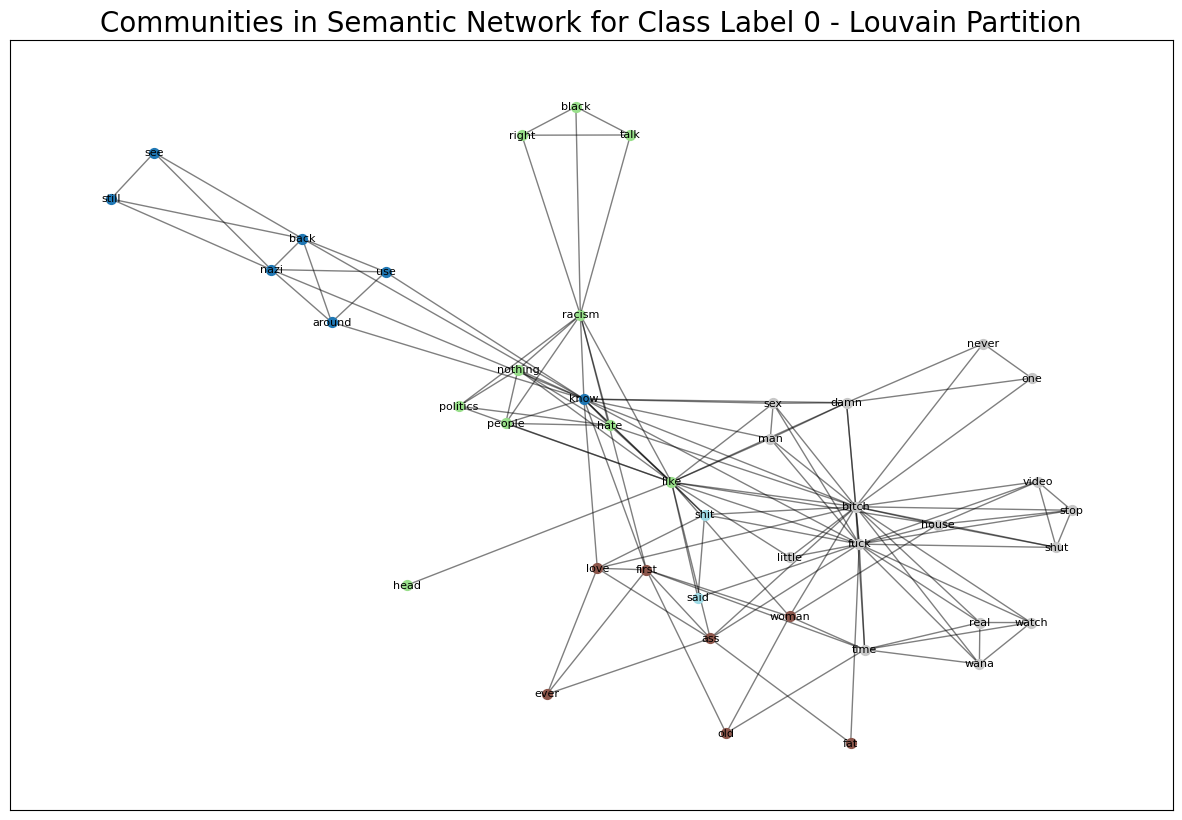

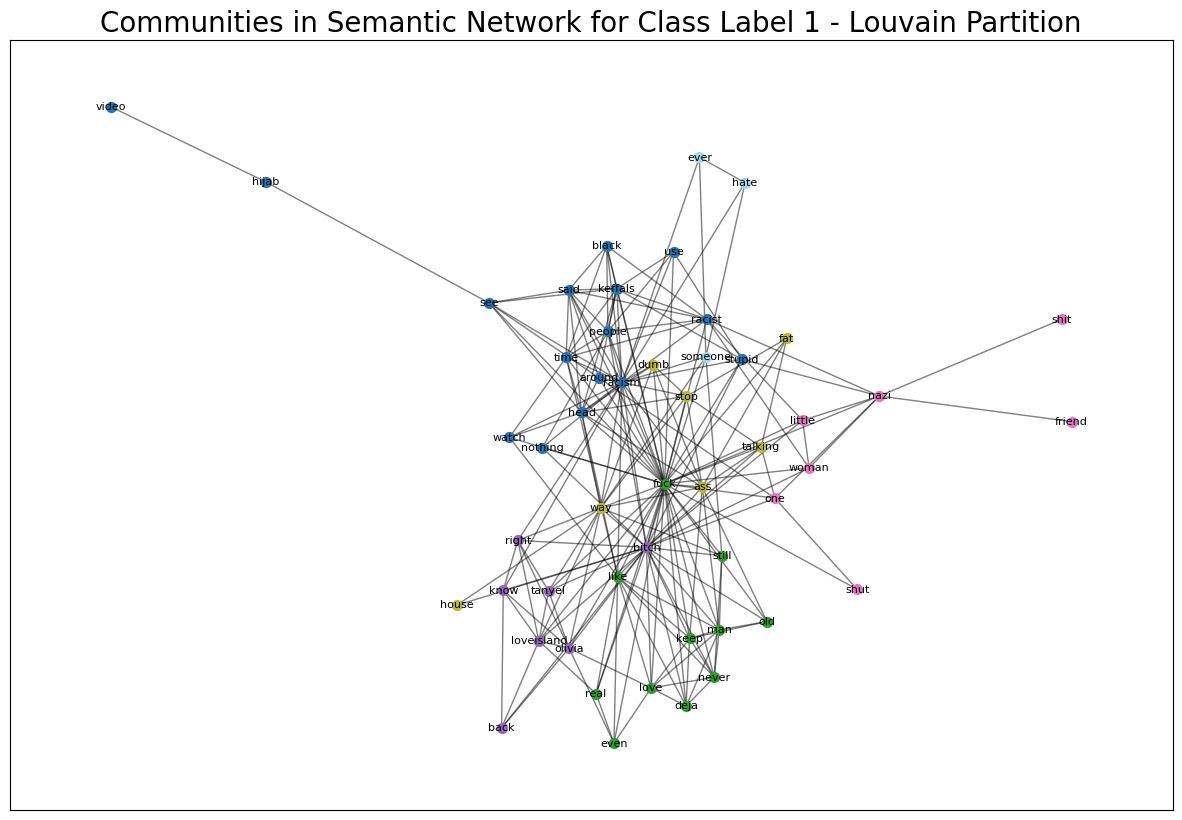

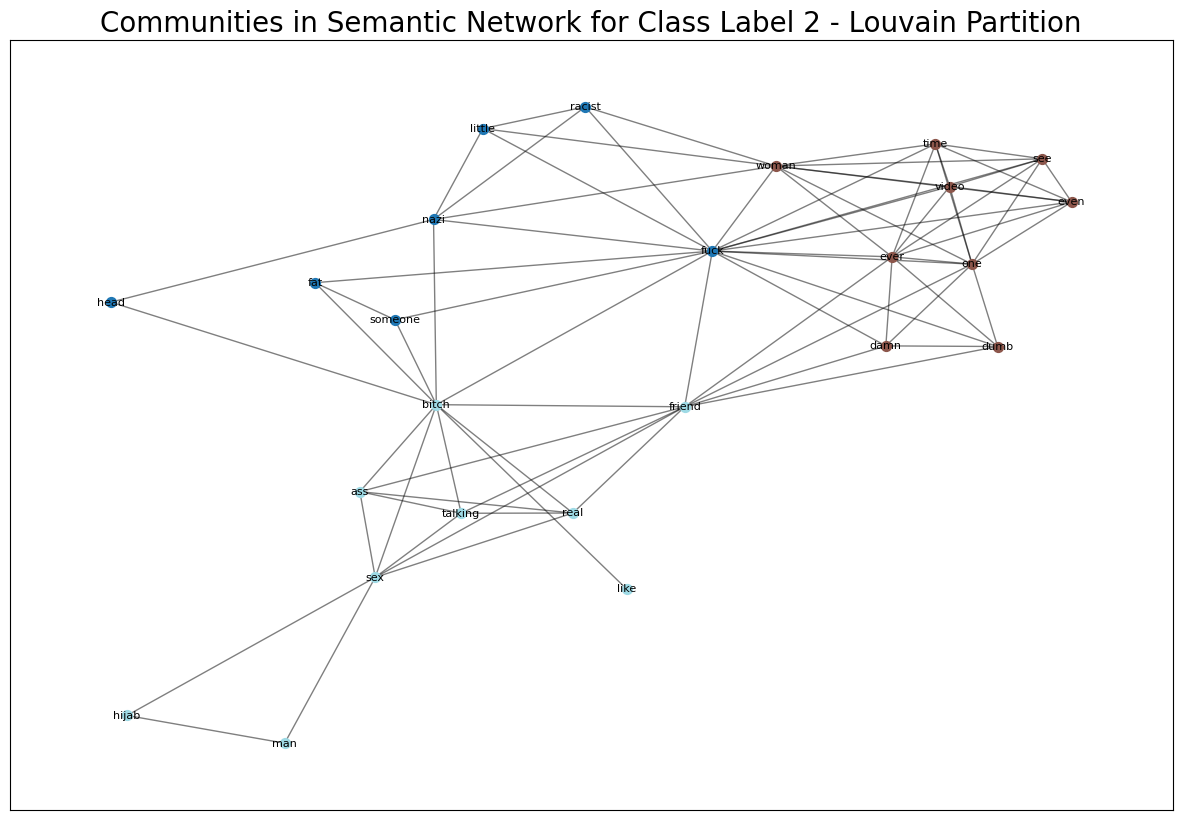

In [ ]:
import community.community_louvain as community_louvain

# Convert NetworkX graph to igraph
def nx_to_igraph(nx_graph):
    mapping = {node: idx for idx, node in enumerate(nx_graph.nodes())}
    reverse_mapping = {idx: node for node, idx in mapping.items()}
    ig_graph = ig.Graph(directed=False)
    ig_graph.add_vertices(len(nx_graph.nodes()))
    ig_graph.add_edges([(mapping[u], mapping[v]) for u, v in nx_graph.edges()])
    return ig_graph, reverse_mapping

# Plot communities
def plot_communities(nx_graph, partition, title):
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(nx_graph, seed=42)

    # Create a color map for communities
    color_map = plt.get_cmap('tab20')
    colors = color_map(np.linspace(0, 1, len(partition)))

    for community_index, community in enumerate(partition):
        nx.draw_networkx_nodes(nx_graph, pos, nodelist=community, node_color=[colors[community_index]], node_size=50)
    nx.draw_networkx_edges(nx_graph, pos, alpha=0.5)
    nx.draw_networkx_labels(nx_graph, pos, font_size=8, font_color='black')

    plt.title(title, fontsize=20)
    plt.show()

# Create and plot communities for each class label
for class_label in [0, 1, 2]:
    if class_label in class_networks:
        graph = class_networks[class_label]
        ig_graph, reverse_mapping = nx_to_igraph(graph)

        # Apply Louvain community detection
        partition = community_louvain.best_partition(graph)

        # Convert partition to list of lists of nodes
        # Group nodes by community
        communities = {}
        for node, comm in partition.items():
            if comm not in communities:
                communities[comm] = []
            communities[comm].append(node)

        # Convert communities to list of lists
        community_list = list(communities.values())

        plot_communities(graph, community_list, f"Communities in Semantic Network for Class Label {class_label} - Louvain Partition")

In [ ]:
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate network measures
def calculate_network_measures(graph):
    measures = {}
    ig_graph, _ = nx_to_igraph(graph)
    # Degree
    measures['degree'] = dict(graph.degree())

    # Betweenness Centrality
    measures['betweenness_centrality'] = nx.betweenness_centrality(graph)

    # Closeness Centrality
    measures['closeness_centrality'] = nx.closeness_centrality(graph)

    # Leiden Community Detection
    partition_Leiden = la.find_partition(ig_graph, la.ModularityVertexPartition)
    measures['Leiden_communities'] = partition_Leiden

    # Modularity for Leiden
    modularity_Leiden = ig_graph.modularity(partition_Leiden)
    measures['modularity_Leiden'] = modularity_Leiden

    # Louvain Community Detection
    partition = community_louvain.best_partition(graph)
    measures['Louvain_communities'] = partition

    # Modularity Louvain
    modularity_Louvain = community_louvain.modularity(partition, graph)
    measures['modularity_Louvain'] = modularity_Louvain

    return measures

# Calculate measures for each class network
network_measures_per_class = {}
for class_label in sorted(class_networks.keys()):
    graph = class_networks[class_label]
    network_measures_per_class[class_label] = calculate_network_measures(graph)

# Print measures for each class
for class_label in sorted(network_measures_per_class.keys()):
    measures = network_measures_per_class[class_label]
    print(f"Network measures for class {class_label}:")

    # Degree (sorted by node degree)
    sorted_degree = dict(sorted(measures['degree'].items(), key=lambda item: item[1], reverse=True))
    print("Degree:", sorted_degree)

    # Betweenness Centrality (sorted by centrality)
    sorted_betweenness = dict(sorted(measures['betweenness_centrality'].items(), key=lambda item: item[1], reverse=True))
    print("Betweenness Centrality:", sorted_betweenness)

    # Closeness Centrality (sorted by centrality)
    sorted_closeness = dict(sorted(measures['closeness_centrality'].items(), key=lambda item: item[1], reverse=True))
    print("Closeness Centrality:", sorted_closeness)

    # Modularity Leiden
    print("Modularity_Leiden:", measures['modularity_Leiden'])

    # Modularity Louvain
    print("Modularity_Louvain:", measures['modularity_Louvain'])
    print()

Network measures for class 0:
Degree: {'bitch': 22, 'fuck': 19, 'like': 18, 'know': 17, 'racism': 10, 'first': 8, 'time': 8, 'damn': 8, 'hate': 7, 'ass': 7, 'house': 7, 'nazi': 6, 'back': 6, 'nothing': 6, 'woman': 6, 'shit': 6, 'sex': 6, 'man': 6, 'love': 6, 'people': 5, 'stop': 5, 'video': 5, 'shut': 5, 'wana': 5, 'watch': 5, 'real': 5, 'use': 4, 'around': 4, 'politics': 4, 'still': 3, 'see': 3, 'old': 3, 'black': 3, 'talk': 3, 'right': 3, 'said': 3, 'little': 3, 'one': 3, 'never': 3, 'ever': 3, 'fat': 2, 'head': 1}
Betweenness Centrality: {'know': 0.32724932249322497, 'bitch': 0.23521293070073562, 'like': 0.19937959736740227, 'fuck': 0.16333914053426254, 'racism': 0.14926829268292682, 'first': 0.06358207510646535, 'nazi': 0.046341463414634146, 'back': 0.046341463414634146, 'ass': 0.03155923344947735, 'time': 0.024008904374758024, 'damn': 0.023495934959349592, 'hate': 0.019742547425474252, 'woman': 0.017960704607046067, 'love': 0.016761517615176153, 'house': 0.010641695702671315, 'shi

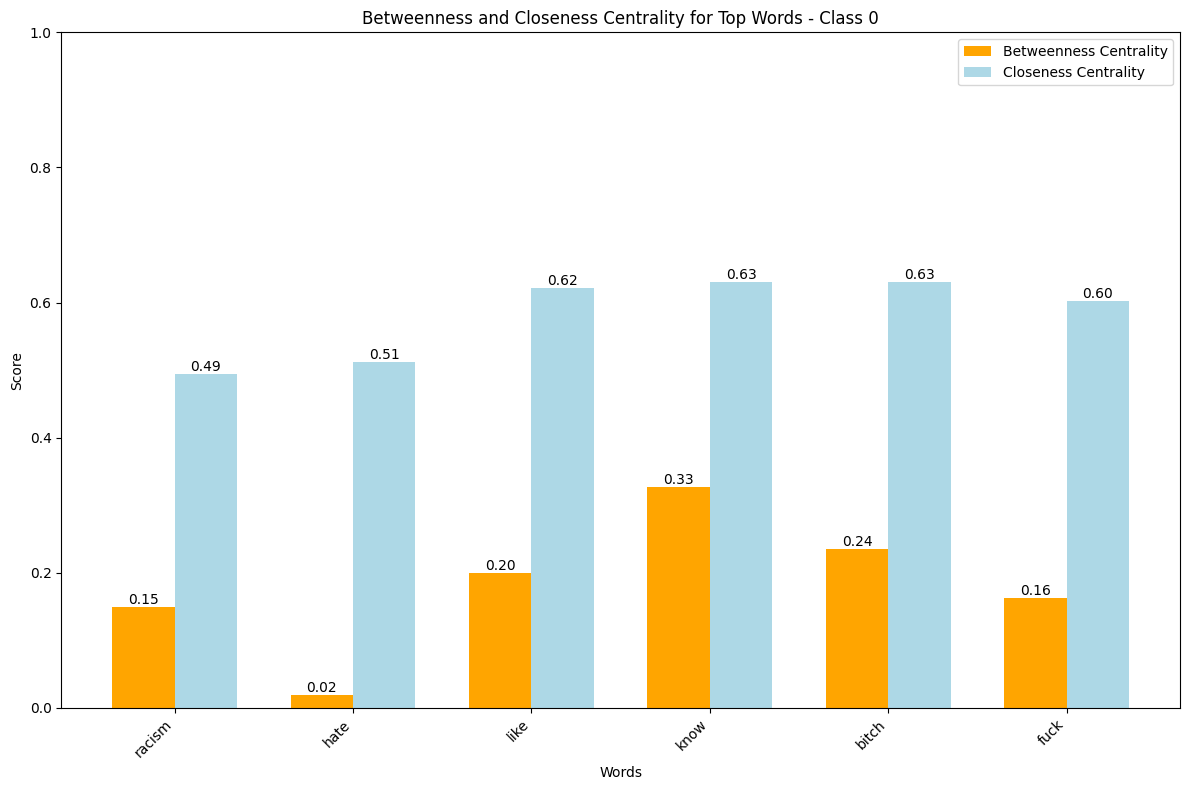

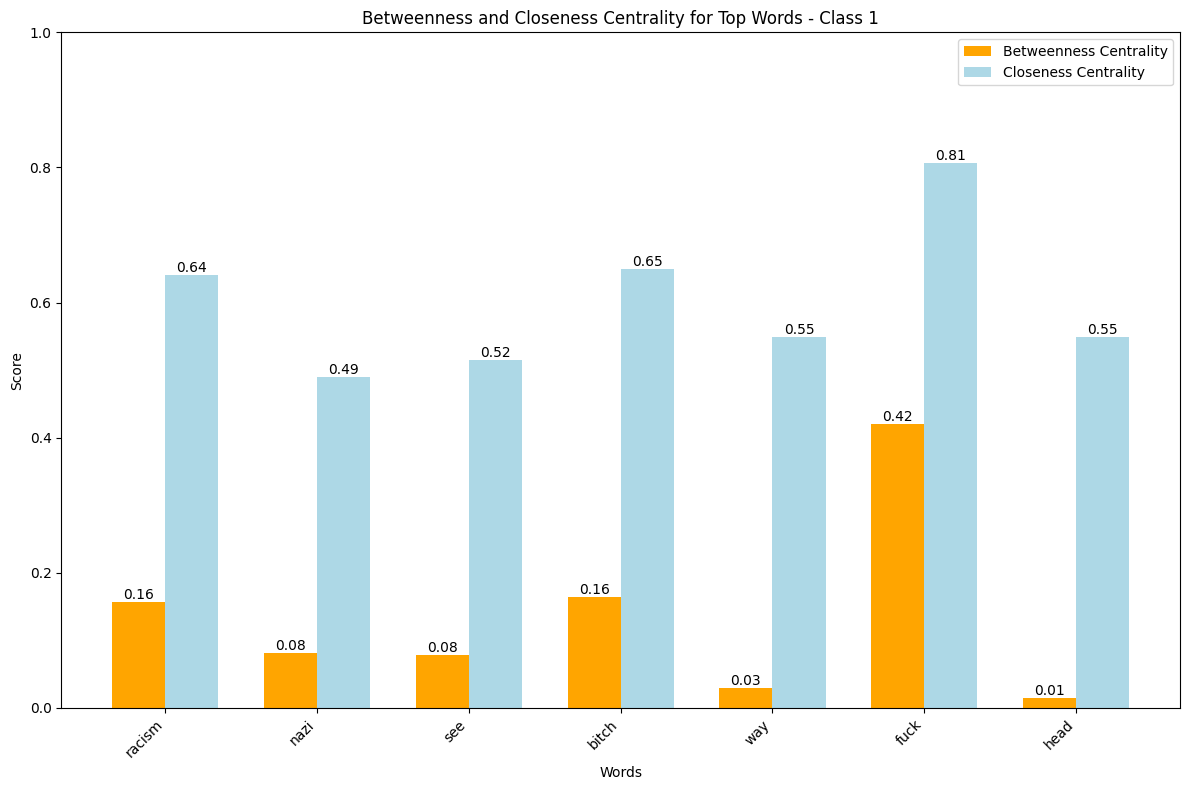

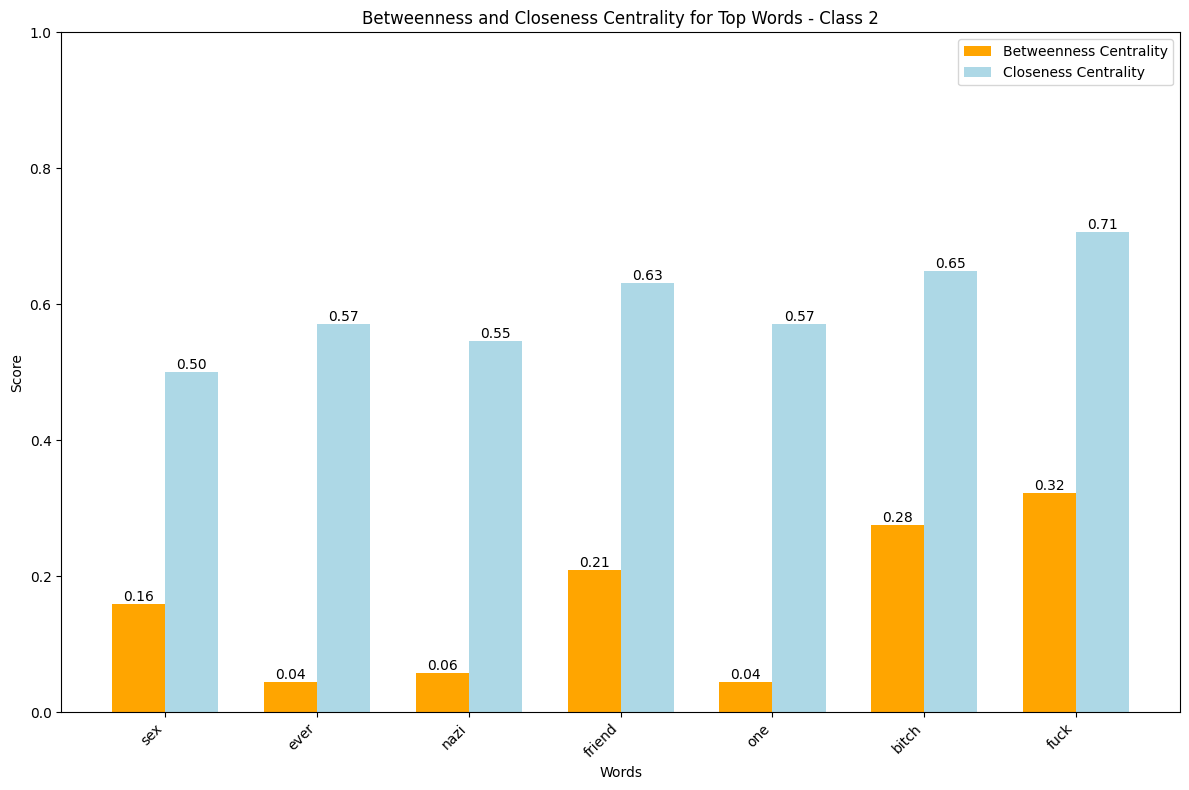

In [ ]:
# Function to plot histograms for Betweenness and Closeness Centrality for top words
def plot_centrality_histograms(network_measures_per_class):
    for class_label, measures in network_measures_per_class.items():
        # Get all words and their Betweenness Centrality values
        all_betweenness = measures['betweenness_centrality']
        # Get all words and their Closeness Centrality values
        all_closeness = measures['closeness_centrality']

        # Combine words from both measures
        all_words = set(all_betweenness.keys()).union(set(all_closeness.keys()))

        # Prepare data for plotting
        betweenness_values = [all_betweenness.get(word, 0) for word in all_words]
        closeness_values = [all_closeness.get(word, 0) for word in all_words]

        # Sort words by Betweenness Centrality and Closeness Centrality
        sorted_words_by_betweenness = sorted(all_words, key=lambda word: all_betweenness.get(word, 0), reverse=True)
        sorted_words_by_closeness = sorted(all_words, key=lambda word: all_closeness.get(word, 0), reverse=True)

        # Select the top words based on their original rates in the entire dataset
        top_words = set(sorted_words_by_betweenness[:5]).union(set(sorted_words_by_closeness[:5]))

        # Prepare data for plotting only for the top words
        betweenness_values = [all_betweenness.get(word, 0) for word in top_words]
        closeness_values = [all_closeness.get(word, 0) for word in top_words]

        # Plotting
        fig, ax = plt.subplots(figsize=(12, 8))
        index = np.arange(len(top_words))
        bar_width = 0.35

        # Bars for Betweenness Centrality
        bars1 = ax.bar(index - bar_width / 2, betweenness_values, bar_width, label='Betweenness Centrality', color='orange')
        # Bars for Closeness Centrality
        bars2 = ax.bar(index + bar_width / 2, closeness_values, bar_width, label='Closeness Centrality', color='lightblue')

        ax.set_xlabel('Words')
        ax.set_ylabel('Score')
        ax.set_title(f'Betweenness and Closeness Centrality for Top Words - Class {class_label}')
        ax.set_xticks(index)
        ax.set_xticklabels(top_words, rotation=45, ha='right')
        ax.legend()
        # Set y-axis limits
        ax.set_ylim(0.0, 1.0)

        # Add value labels on top of bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

# Plot histograms for each class network
plot_centrality_histograms(network_measures_per_class)
